August: Final Mackenzie Canyon bathymetry. This notebook reviews and modifies the functions used to create the bathymetry profiles of a shelf, slope, and canyon. The original functions can be found in https://bitbucket.org/canyonsubc/buildcanyon/src/f2380a66a5fe4fc9e373e46f409a57c5fa4b8f9d/PythonModulesMITgcm/BathyPythonTools.py.

In [8]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.cm as cm
%matplotlib inline

### Bathymetry Functions

This code should be able to work for any canyon. Additional bathymetric details can be added as extra if loops and their corresponding slopes. Note that some portions were added and removed from the original functions to suit what I wanted for Mackenzie Canyon.

In [63]:
def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    """
    
    sls_ct = (z_wall - z_break) / (y_coast - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] < y_coast:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_break) + z_break
                                  
        elif y[jj] >= y_coast:
            topo_sp[jj] = z_wall

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile
   
def canyontopo(y, y_base, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    """
    
    slc_L = (z_break - z_bottom) / (y_head - y_base)
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile
   
def widthprofile(y, y_base, y_break, y_head, cR,
                 w_break, w_mid, w_head, p):
    
    """ This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    """

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            if y[l] >= y_head:
                wp[l] = wp[l-1]
        
    width_profile = wp 
    return width_profile

def make_topo_smooth(y, y_base, y_break, y_head, y_coast, cR,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_break, z_wall):
    
    """ This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. 
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    """
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast,
                                fluid_depth, z_bottom, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, cR,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    #topography=np.transpose(topography)
    topo = topography[0:-1, :]
   
    return topo

### Dimensions specific to Mackenzie Canyon (Beaufort Sea)

In [53]:
# Alongshore
w_break = 62682.0
w_mid = 45763.0
w_head = 14142.1356237
x_wall = 4 * w_break

# Cross-shore
cR = 9246.0
L = 93744.0
y_wall = 174732.0 
y_base = np.mean([16500.0,7000.0])
y_break = np.mean([38000.0, 57500.0])
y_coast = 148105.0
y_head = y_break + L

# Depths
fluid_depth = 1300.0
z_bottom = fluid_depth - fluid_depth
z_break = fluid_depth - 80.0
z_wall = fluid_depth - 40.0
p = 4.0

#y_bc = 51865.0 
#z_bc = fluid_depth - 300.0

### Setting up the grid

In [54]:
# Reference: Notebooks by Karina Ramos Musalem https://bitbucket.org/canyonsubc/buildcanyon

xsize = 501
xgrd_all = np.arange(0, xsize, 1)
xgrd_bounds = [0, xsize-1]
xval_bounds = [0, x_wall]
xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
x_edge = np.zeros(xsize)
x_edge[:] = xval_all[:]
x = ((x_edge[1:] + x_edge[0:-1])/2)

ysize = 351
ygrd_all = np.arange(0, ysize, 1)
ygrd_bounds = [0, ysize-1]
yval_bounds = [0, y_wall]
yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
y_edge = np.zeros(ysize)
y_edge[:] = yval_all[:]
y = ((y_edge[1:] + y_edge[0:-1])/2)

### Make bathymetry

In [64]:
bathymetry = make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR,
                              x, x_wall, w_break, w_mid, w_head, p,
                              fluid_depth, z_bottom, z_break, z_wall)
bathymetry.shape

(350, 500)

### Mackenzie Canyon:

(350, 500)


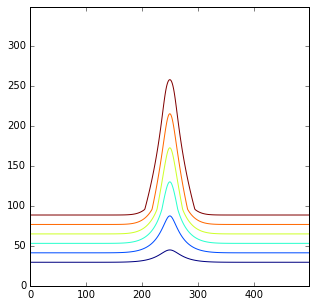

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cs = ax.contour(bathymetry)
print(bathymetry.shape)

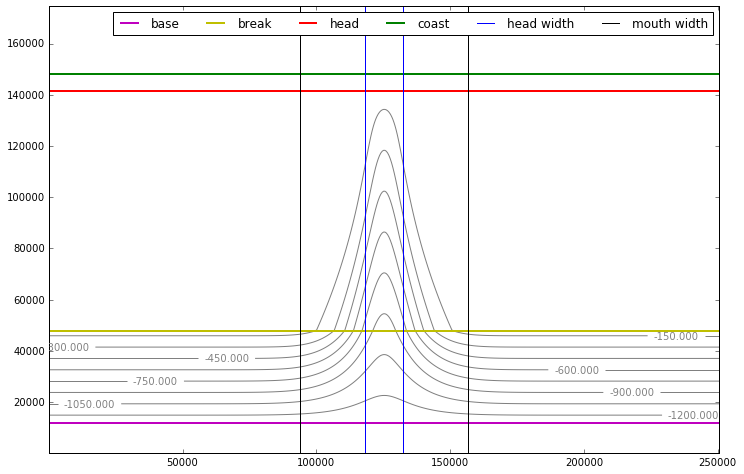

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
X, Y = np.meshgrid(x, y)
cs = ax.contour(X, Y, bathymetry, 10, colors='grey', linestyles='solid')
ax.clabel(cs, inline=1)

ys = [y_base, y_break, y_head, y_coast]
labs = ['base', 'break', 'head', 'coast']
cs = ['m', 'y', 'r', 'g']
for i, j, k in zip(ys, labs, cs):
    ax.axhline(i, c=k, label=j, linewidth=2)
#plt.axvline(x[250]); plt.axvline(x[300]); plt.axvline(x[400])
ax.axvline((x_wall/2)-(w_head/2)); plt.axvline((x_wall/2)+(w_head/2), label='head width')
ax.axvline((x_wall/2)+(w_break/2), c='k'); plt.axvline((x_wall/2)-(w_break/2), c='k', label='mouth width')
ax.legend(ncol=7)

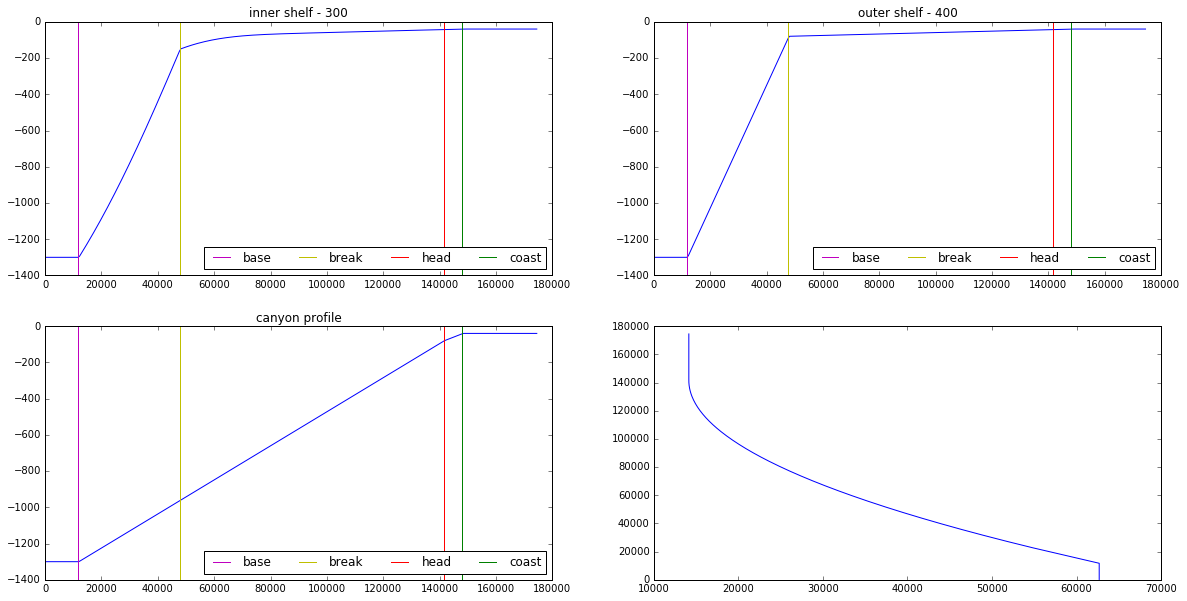

In [73]:
fig, [(ax1, ax2),(ax3, ax4)] = plt.subplots(2, 2, figsize=(20,10))
ax1.plot(y, bathymetry[:, 300] )
ax1.set_title('inner shelf - 300')
ax2.plot(y, bathymetry[:, 400] )
ax2.set_title('outer shelf - 400')
ax3.plot(y, bathymetry[:, 250] )
ax3.set_title('canyon profile')

for ax, n in zip([ax1, ax2, ax3], np.arange(3)):
    ys = [y_base, y_break, y_head, y_coast]
    labs = ['base', 'break', 'head', 'coast']
    cs = ['m', 'y', 'r', 'g']
    for i, j, k in zip(ys, labs, cs):
        ax.axvline(i, c=k, label=j)
        ax.legend(ncol=5, loc=4)
        
width_test = widthprofile(y, y_base, y_break, y_head, cR, w_break, w_mid, w_head, p)
ax4.plot(width_test, y)

### Making bathymetry file

In [81]:
import netCDF4 as nc
from netCDF4 import Dataset
import time

In [84]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/Bathy_Mackenzie_1.nc')
bathy_file, bathy_file.variables

(<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     title: Mackenzie Canyon Bathymetry 1
     author: Idalia A. Machuca
     institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
     source: bitbucket.org/CanyonsUBC/mackenzie_canyon/bathymetry/notebooks/make_mackenzie.ipynb
     timeStamp: Wed Aug 17 17:03:59 2016
     dimensions(sizes): x(500), y(350)
     variables(dimensions): float64 X(y,x), float64 Y(y,x), float64 Bathymetry(y,x)
     groups: , OrderedDict([('X', <class 'netCDF4._netCDF4.Variable'>
               float64 X(y, x)
                   standard_name: Along-Shore Distance
                   units: m
               unlimited dimensions: 
               current shape = (350, 500)
               filling on, default _FillValue of 9.969209968386869e+36 used),
              ('Y', <class 'netCDF4._netCDF4.Variable'>
               float64 Y(y, x)
                   standard_name: Cross-Shore Distance


In [85]:
AS = bathy_file.variables['X']
CS = bathy_file.variables['Y']
bathy = bathy_file.variables['Bathymetry']

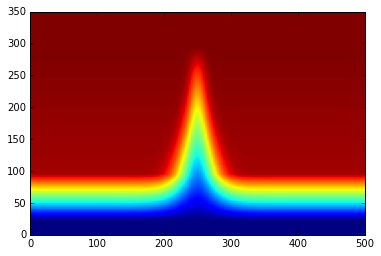

In [88]:
plt.pcolor(bathy)